# A Framework for Leveraging LLMs for Scene Analysis and Cognitive Processing

## Setup

In [6]:
import os
HOME = os.getcwd()

os.chdir(HOME)
print(HOME)

/Users/162191/Documents/GitHub/human_patterns_exploration


In [7]:
import os
HOME = os.getcwd()

import openai
import ollama

import time
import base64

import numpy as np

from classes.ImageData import ImageData

import pandas as pd

from IPython.display import display, HTML

from utils.llm_utils import *
from utils.experiment_data import *

import utils.style as stl
from utils.experiment_utils import *

import matplotlib.pyplot as plt

from utils.prompts import *

import pickle

In [8]:

DATA_DIR = os.path.join(HOME, "data", "experiments")
IMAGE_DIR = os.path.join(HOME, "data", "images")
RESULTS_DIR = os.path.join(HOME, "outputs")

SAM_CONFIG = os.path.join("configs", "sam2.1", "sam2.1_hiera_l.yaml")
SAM_MODEL =  os.path.join(HOME, "checkpoints", "sam2.1_hiera_large.pt")

print("HOME:", HOME)
print("DATA_DIR:", DATA_DIR)
print("IMAGE_DIR:", IMAGE_DIR)
print("SAM_CONFIG:", SAM_CONFIG)
print("SAM_MODEL:", SAM_MODEL)

HOME: /Users/162191/Documents/GitHub/human_patterns_exploration
DATA_DIR: /Users/162191/Documents/GitHub/human_patterns_exploration/data/experiments
IMAGE_DIR: /Users/162191/Documents/GitHub/human_patterns_exploration/data/images
SAM_CONFIG: configs/sam2.1/sam2.1_hiera_l.yaml
SAM_MODEL: /Users/162191/Documents/GitHub/human_patterns_exploration/checkpoints/sam2.1_hiera_large.pt


## Participant Gaze

In [9]:
prompt_diameter = 10
prompt_n_points = 5

# colors for eye gaze plots
font_color =  "yellow"          
COLOR_CODE_1 = "fixation_scarletred_meddark"
COLOR_CODE_2 = "aluminium"
COLOR_CODE_3 = "yellow"

In [10]:
# load experiment data
data_path = os.path.join(DATA_DIR , "XSQ_Expt1_Data_2.csv")
data = pd.read_csv( data_path )
data.head()


,ParticipantID,Group,Condition,ItemNum,X,Y,FixationDuration,Rel_Scene_Region_Rel_X1,Rel_Scene_Region_Rel_Y1,Rel_Scene_Region_Rel_X2,...,Irrev_Scene_Region_X1,Irrev_Scene_Region_Y1,Irrev_Scene_Region_X2,Irrev_Scene_Region_Y2,Irrev_Scene_Region_IrrelSceneFix,Cntl_Scene_Region_X1,Cntl_Scene_Region_Y1,Cntl_Scene_Region_X2,Cntl_Scene_Region_Y2,Cntl_Scene_Region_CntlSceneFix
0,2,1,1,1,398.0,314.2,291,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,0.0
1,2,1,1,1,323.4,398.2,421,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
2,2,1,1,1,23.6,492.2,268,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
3,2,1,1,1,483.6,565.0,162,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
4,2,1,1,2,379.6,305.1,206,0.0,435.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,0.0


## Image Segmentation and Mask Generation

In [6]:
CENTER_BIAS_SECONDS = 1    # remove first 1 second of data to remove center bias

prompt_types = ["point", "circle", "triangle", "cross"]

GENERATE_MASKS = False

if GENERATE_MASKS:      
    for img_id in range(1, 2):
        for prompt_type in prompt_types:
            image_data = segment_image(img_id, data, condition_id=1, center_bias_seconds=CENTER_BIAS_SECONDS, prompt_type=prompt_type,  img_type="exp")
            #image_data = segment_image(img_id, data, condition_id=3, center_bias_seconds=CENTER_BIAS_SECONDS, prompt_type=prompt_type,  img_type="unexp")


### Find the best mask for each participant

In [39]:
IMG_ID = 1
IMG_TYPE = "exp"
PROMPT_TYPE = "point"

participant_ids = get_participant_ids( os.path.join(RESULTS_DIR, "masks_gaze_driven", PROMPT_TYPE) , IMG_TYPE) 
print("Total participants: ", len(participant_ids))


Total participants:  17


20


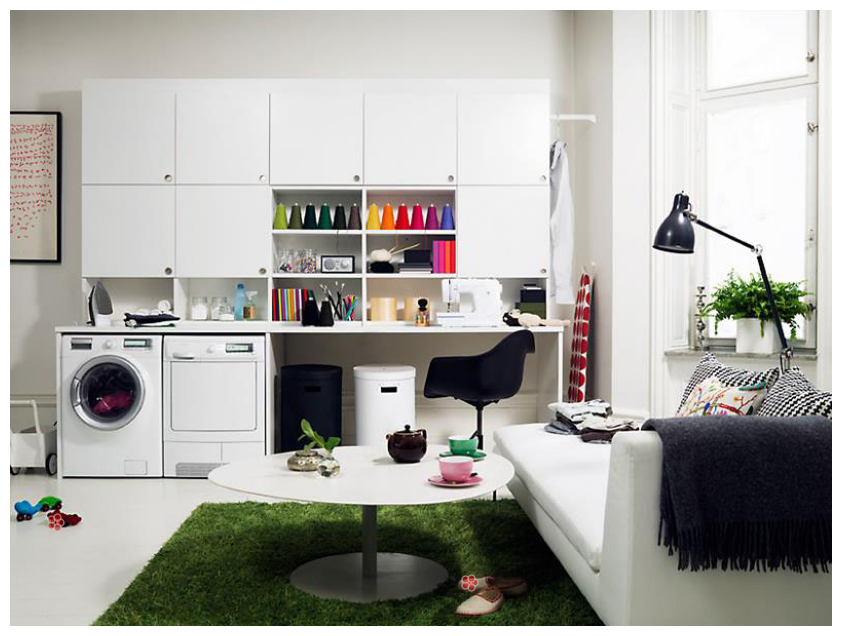

In [8]:
P_INDX = 3
print(participant_ids[P_INDX])
img_data, participant_data = load_image_data(IMG_ID, IMG_TYPE, participant_id=participant_ids[P_INDX], prompt_type=PROMPT_TYPE)

img_data.draw_fixations( participant_data, fix_color=stl.COLORS[COLOR_CODE_1][0], fix_edge_color=stl.COLORS[COLOR_CODE_2][1], size = 25 )


Processing mask 0 for participant 15


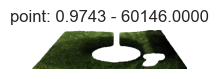

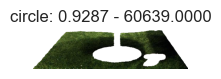

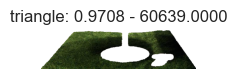

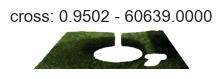

Processing mask 1 for participant 15


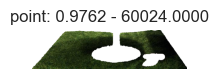

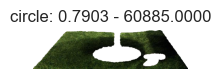

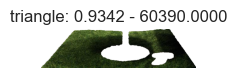

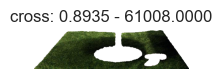

Processing mask 2 for participant 15


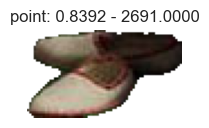

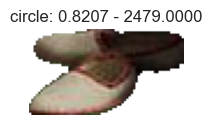

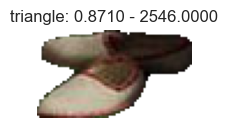

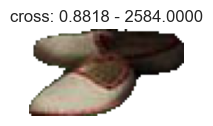

In [9]:
get_mask_candidates(1, 15, prompt_types, "exp")


In [ ]:
find_best_mask(IMG_ID, participant_ids, prompt_types, IMG_TYPE)


In [10]:
P_INDX = 0
img_scene_data, participant_data = load_image_data(IMG_ID, IMG_TYPE, participant_id=participant_ids[P_INDX], prompt_type=PROMPT_TYPE)

In [11]:
def label_masks_openai(participant_ids, num_images, img_type, model="gpt-4o", filename = "best_labels", output_dir = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling") ):

    df = pd.DataFrame(columns=["participant_id", "image_id", "image_path", "mask_id", "mask_path", "xmin", "xmax", "ymin", "ymax", "prompt_type", "X", "Y", "label1", "label2", "label3", "label4", "label5", "label6", "label7", "label8", "label9", "label10", "best_label", "scene_desc"])

    row = 0
    for part_indx in range(len(participant_ids)):

        print(f"Processing participant {part_indx}/{len(participant_ids)}")
        participant_id = participant_ids[part_indx]

        for img_id in range(1, num_images+1):

            img_scene_data, _ = load_image_data(img_id, img_type, participant_id=participant_id, prompt_type="point")
            image_path = img_scene_data.path

            scene_desc = open_ai_scene_description(img_scene_data, temperature=0.1)
            scene_desc = scene_desc.replace("*", "")

            res = load_best_masks(img_id, participant_id, IMG_TYPE)

            mask_keys = list(res.keys())
            labels = []
            for mask_key in mask_keys:
                mask_id = mask_key
                mask_path = res[mask_id].path
                xmin = res[mask_id].x_min
                xmax = res[mask_id].x_max
                ymin = res[mask_id].y_min
                ymax = res[mask_id].y_max
                prompt_type = res[mask_id].prompt_type
                prompt = res[mask_id].prompt[0]
                
                for i in range(1, 11):
                    mask_label = open_ai_mask_labeling(res[mask_id], temperature=0.1)

                    # if mask label is of type list, then append the first element to the labels list
                    if isinstance(mask_label, list):
                        labels.append(mask_label[0].replace("- ", ""))
                    else:
                        labels.append(mask_label.replace("- ", ""))
                
                print(labels)

                # get the most frequent label from the list
                best_label = most_frequent_label(labels)

                df.loc[row] = [participant_id, img_id, image_path, mask_id, mask_path, xmin, xmax, ymin, ymax, prompt_type, prompt[0],prompt[1],labels[0], labels[1], labels[2], labels[3], labels[4], labels[5], labels[6], labels[7], labels[8], labels[9], best_label, scene_desc]
                row += 1
                labels = []
    
    df.to_csv(os.path.join(output_dir, f"{filename}_{model}_{IMG_TYPE}.csv"), index=False)
    return df


from collections import Counter

def most_frequent_label(labels):
    if not labels:
        return None  # Return None if the list is empty
    
    label_counts = Counter(labels)
    most_common_label, _ = label_counts.most_common(1)[0]  # Get the most frequent label
    
    return most_common_label


In [ ]:
df =  label_masks_openai(participant_ids, 1, "exp", model="gpt-4o", output_dir = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling") )


Animation saved to fixation_animation_78.mp4


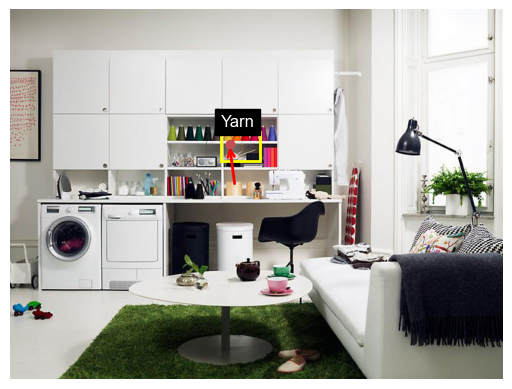

In [80]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from PIL import Image
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os


def animate_fixations(csv_path, participant_id, output_path):
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Filter data for the given participant_id
    df_participant = df[df['participant_id'] == participant_id].copy()
    
    if df_participant.empty:
        print(f"No data found for participant {participant_id}")
        return
    
    # Ensure X, Y, bbox coordinates are valid (not NaN and numeric)
    df_participant.dropna(subset=['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax', 'best_label'], inplace=True)
    df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']] = df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']].apply(pd.to_numeric, errors='coerce')
    
    if len(df_participant) < 2:
        print(f"Not enough valid fixation points for animation (found {len(df_participant)}).")
        return
    
    # Load the image and check if it exists
    image_path = df_participant.iloc[0]['image_path']
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    
    image = Image.open(image_path)
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    
    # Initialize elements
    fixation_dot, = ax.plot([], [], 'ro', markersize=6)
    bbox_patch = patches.Rectangle((0, 0), 0, 0, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(bbox_patch)
    label_text = ax.text(10, 10, '', fontsize=12, color='white', backgroundcolor='black')
    arrow = ax.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    def update(frame):
        if frame >= len(df_participant):
            return []  # Avoid out-of-range error
        
        row = df_participant.iloc[frame]
        
        # Ensure numeric values
        try:
            x, y = float(row['X']), float(row['Y'])
            xmin, xmax, ymin, ymax = float(row['xmin']), float(row['xmax']), float(row['ymin']), float(row['ymax'])
        except ValueError:
            print(f"Invalid numeric values in frame {frame}, skipping.")
            return []
        
        # Update fixation dot
        fixation_dot.set_data([x], [y])  # Ensuring sequence format
        
        # Update bounding box
        bbox_patch.set_xy((xmin, ymin))
        bbox_patch.set_width(xmax - xmin)
        bbox_patch.set_height(ymax - ymin)
        
        # Update label text
        label_text.set_text(row['best_label'])
        label_text.set_position((xmin, ymin - 10))
        
        # Update arrow from previous fixation to the current one
        if frame > 0:
            prev_row = df_participant.iloc[frame - 1]
            prev_x, prev_y = float(prev_row['X']), float(prev_row['Y'])
            arrow.set_position((prev_x, prev_y))
            arrow.xy = (x, y)
        
        return fixation_dot, bbox_patch, label_text, arrow
    
    ani = FuncAnimation(fig, update, frames=len(df_participant), interval=1000, repeat=False)
    
    # Save animation to MP4 with error handling
    try:
        writer = FFMpegWriter(fps=1, metadata={"artist": "Matplotlib"})
        ani.save(output_path, writer=writer)
        print(f"Animation saved to {output_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
    
    plt.show()
    
    return ani

#
# Example usage:
csv_file = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling", "best_labels_gpt-4o_exp.csv")
participant_id = 78
output_video = "fixation_animation_78.mp4"
animate_fixations(csv_file, participant_id, output_video)


Animation saved to fixation_animation_21.mp4


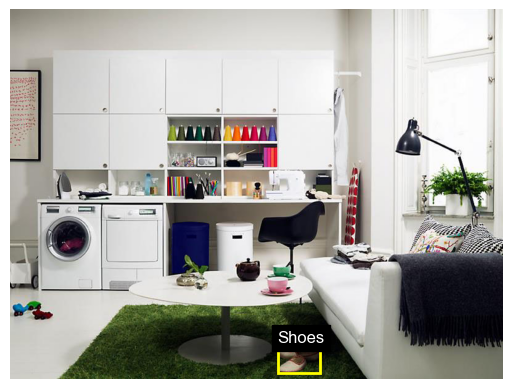

In [103]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from PIL import Image
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
import pickle
from classes.ImageData import ImageData

def animate_fixations(csv_path, participant_id, output_path):
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Filter data for the given participant_id
    df_participant = df[df['participant_id'] == participant_id].copy()
    
    if df_participant.empty:
        print(f"No data found for participant {participant_id}")
        return
    
    # Ensure X, Y, bbox coordinates are valid (not NaN and numeric)
    df_participant.dropna(subset=['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax', 'best_label', 'mask_path'], inplace=True)
    df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']] = df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']].apply(pd.to_numeric, errors='coerce')
    
    if len(df_participant) < 2:
        print(f"Not enough valid fixation points for animation (found {len(df_participant)}).")
        return
    
    # Load the image and check if it exists
    image_path = df_participant.iloc[0]['image_path']
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    
    image = Image.open(image_path).convert("RGBA")
    img_width, img_height = image.size
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    
    # Initialize elements
    fixation_dot, = ax.plot([], [], 'ro', markersize=6)
    bbox_patch = patches.Rectangle((0, 0), 0, 0, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(bbox_patch)
    label_text = ax.text(10, 10, '', fontsize=12, color='white', backgroundcolor='black')
    arrow = ax.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='red', lw=2))
    mask_overlay = ax.imshow(np.zeros((img_height, img_width, 4), dtype=np.uint8), alpha=0)  # Placeholder for mask overlay
    
    def update(frame):
        if frame >= len(df_participant):
            return []  # Avoid out-of-range error
        
        row = df_participant.iloc[frame]
        
        # Ensure numeric values
        try:
            x, y = float(row['X']), float(row['Y'])
            xmin, xmax, ymin, ymax = float(row['xmin']), float(row['xmax']), float(row['ymin']), float(row['ymax'])
        except ValueError:
            print(f"Invalid numeric values in frame {frame}, skipping.")
            return []
        
        # Load and overlay mask from pickle file
        mask_path = row['mask_path'].replace("png", "pkl")
        if os.path.exists(mask_path):
            with open(mask_path, 'rb') as f:
                try:
                    mask_data = pickle.load(f)
                    mask = mask_data.cropped_mask  # Extract mask from pickle object
                    mask = np.array(mask, dtype=np.uint8)  # Ensure it is uint8
                    mask_binary = mask > 0  # Convert to boolean mask
                    
                    # Create an RGBA overlay the same size as the image
                    mask_colored = np.zeros((img_height, img_width, 4), dtype=np.uint8)
                    
                    # Map the mask to its correct bounding box position
                    mask_xmin, mask_xmax = mask_data.x_min, mask_data.x_max
                    mask_ymin, mask_ymax = mask_data.y_min, mask_data.y_max
                    
                    mask_resized = np.zeros((img_height, img_width), dtype=np.uint8)
                    mask_resized[mask_ymin:mask_ymax, mask_xmin:mask_xmax] = mask
                    
                    # Apply blue color to mask
                    mask_colored[mask_resized > 0] = [0, 0, 255, 100]  # Blue with transparency
                    
                    mask_overlay.set_data(mask_colored)
                    mask_overlay.set_alpha(0.8)  # Adjust transparency
                    fig.canvas.draw()  # Ensure the last frame updates properly
                except Exception as e:
                    print(f"Error loading mask file {mask_path}: {e}")
        
        # Update fixation dot
        fixation_dot.set_data([x], [y])  # Ensuring sequence format
        
        # Update bounding box
        bbox_patch.set_xy((xmin, ymin))
        bbox_patch.set_width(xmax - xmin)
        bbox_patch.set_height(ymax - ymin)
        
        # Update label text
        label_text.set_text(row['best_label'])
        label_text.set_position((xmin, ymin - 10))
        
        # Update arrow from previous fixation to the current one
        if frame > 0:
            prev_row = df_participant.iloc[frame - 1]
            prev_x, prev_y = float(prev_row['X']), float(prev_row['Y'])
            arrow.set_position((prev_x, prev_y))
            arrow.xy = (x, y)
        
        return fixation_dot, bbox_patch, label_text, arrow, mask_overlay
    
    ani = FuncAnimation(fig, update, frames=len(df_participant), interval=1000, repeat=False)
    
    # Save animation to MP4 with error handling
    try:
        writer = FFMpegWriter(fps=0.5, metadata={"artist": "Matplotlib"})
        ani.save(output_path, writer=writer)
        print(f"Animation saved to {output_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
    
    plt.show()
    
    return ani

# Example usage:
csv_file = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling", "best_labels_gpt-4o_exp.csv")
participant_id = 21
output_video = f"fixation_animation_{participant_id}.mp4"
animate_fixations(csv_file, participant_id, output_video)


In [53]:

# open the knowledge graph
with open(kg_path, 'rb') as file:
    kg = pickle.load(file)

kg

In [58]:
import networkx as nx

In [61]:
edge_labels = nx.get_edge_attributes(kg, "label")
print(edge_labels)


{('Slippers', 'Rug'): 'ARE_ON', ('Slippers', 'Toy'): 'ARE_CLOSE_TO', ('Rug', 'Coffee table'): 'IS_UNDER', ('Rug', 'Green'): 'HAS_COLOR', ('Toy', 'Sofa'): 'IS_NEAR', ('Sofa', 'Wall'): 'IS_AGAINST', ('Sofa', 'White'): 'HAS_COLOR', ('Sofa', 'Comfortable'): 'HAS_PROPERTY', ('Sofa', 'Workspace desk'): 'IS_NEAR', ('Coffee table', 'Relaxation'): 'IS_USED_FOR', ('Clothes', 'Ironing board'): 'ARE_NEAR', ('Ironing board', 'Clothes'): 'IS_NEXT_TO', ('Cart', 'Washing machine'): 'IS_NEAR', ('Washing machine', 'Dryer'): 'IS_NEXT_TO', ('Bin', 'Desk'): 'IS_UNDER', ('Desk', 'Cabinets'): 'IS_BELOW', ('Table', 'Sofa'): 'IS_IN_FRONT_OF', ('Teapot', 'Coffee table'): 'IS_ON', ('Teapot', 'Ceramic'): 'HAS_MATERIAL', ('Cups', 'Coffee table'): 'ARE_ON', ('Chair', 'Desk'): 'IS_NEAR', ('Chair', 'Sitting'): 'IS_USED_FOR', ('Chair', 'Metal and Fabric'): 'HAS_MATERIAL', ('Cabinet', 'Desk'): 'IS_OVER', ('Cabinet', 'White'): 'HAS_COLOR', ('Shelves', 'Workspace desk'): 'ARE_OVER', ('Shelves', 'White'): 'HAVE_COLOR', ('

In [71]:
for u, v, data in kg.edges(data=True):
    label = data.get("label", "undefined")  # Get edge label, default to "undefined"
    print(f"{u} [{label}] {v}")


Slippers [ARE_ON] Rug
Slippers [ARE_CLOSE_TO] Toy
Rug [IS_UNDER] Coffee table
Rug [HAS_COLOR] Green
Toy [IS_NEAR] Sofa
Sofa [IS_AGAINST] Wall
Sofa [HAS_COLOR] White
Sofa [HAS_PROPERTY] Comfortable
Sofa [IS_NEAR] Workspace desk
Coffee table [IS_USED_FOR] Relaxation
Clothes [ARE_NEAR] Ironing board
Ironing board [IS_NEXT_TO] Clothes
Cart [IS_NEAR] Washing machine
Washing machine [IS_NEXT_TO] Dryer
Bin [IS_UNDER] Desk
Desk [IS_BELOW] Cabinets
Table [IS_IN_FRONT_OF] Sofa
Teapot [IS_ON] Coffee table
Teapot [HAS_MATERIAL] Ceramic
Cups [ARE_ON] Coffee table
Chair [IS_NEAR] Desk
Chair [IS_USED_FOR] Sitting
Chair [HAS_MATERIAL] Metal and Fabric
Cabinet [IS_OVER] Desk
Cabinet [HAS_COLOR] White
Shelves [ARE_OVER] Workspace desk
Shelves [HAVE_COLOR] White
Shirt [IS_ON] Ironing board
Window [IS_NEAR] Potted plant
Potted plant [ADDS_TO] Decor
Blanket [IS_ON] Sofa
Laundry [IS_NEAR] Dryer
Laundry [IS_FOR] Cleaning
Workspace Desk [HAS_FUNCTION] Sewing
Sewing machine [IS_ON] Workspace desk


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define fixed positions for each node
fixed_positions = {
    "Slippers" : (-1, 2), 
    "Toy" : (-1, 2.5), 
    "Rug" : (0, 2), 
    "Coffee table" : (1, 2),
    "Green" : (1, 2),
    "Sofa" : (-1, 3),
    ""
    

}

# If a node is missing from fixed_positions, use spring_layout as fallback
pos = {node: fixed_positions.get(node, (0, 0)) for node in kg.nodes()}

plt.figure(figsize=(8, 6))

# Draw the graph using fixed positions
nx.draw(kg, fixed_positions, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold", arrowsize=15)

plt.title("Knowledge Graph Visualization")
plt.show()


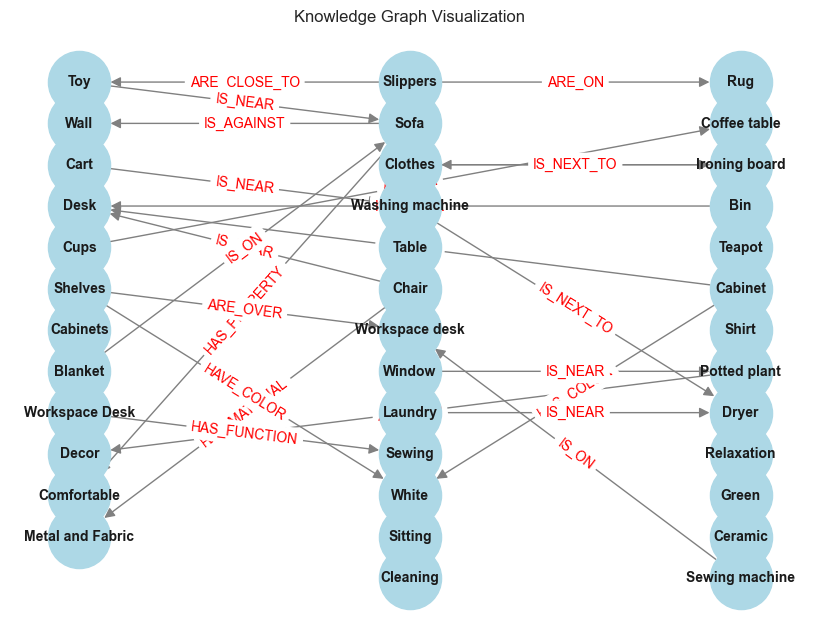

Slippers, Rug, Toy, Sofa, Coffee table, Wall, Clothes, Ironing board, Cart, Washing machine, Bin, Desk, Table, Teapot, Cups, Chair, Cabinet, Shelves, Workspace desk, Shirt, Cabinets, Window, Potted plant, Blanket, Laundry, Dryer, Workspace Desk, Sewing, Relaxation, Decor, White, Green, Comfortable, Sitting, Ceramic, Metal and Fabric, Cleaning, Sewing machine


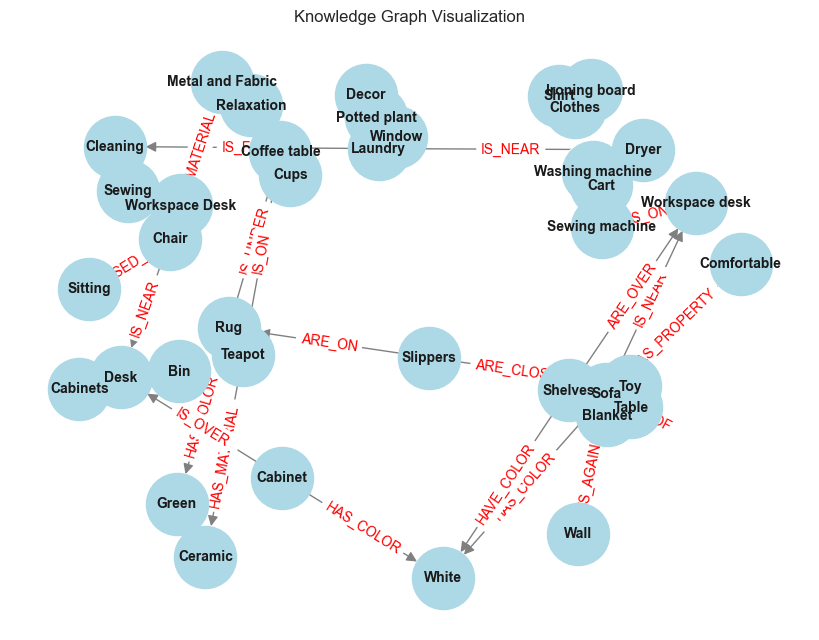

In [68]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(kg)  # Layout for positioning

node_labels = list(kg.nodes())  # Extract node labels
node_labels_str = ", ".join(node_labels)  # Convert to string format
print(node_labels_str)


# Draw the graph
nx.draw(kg, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size = 2000, font_size=10, font_weight="bold", arrowsize=15)

# Extract edge labels if they exist
edge_labels = nx.get_edge_attributes(kg, "label")  # Change "label" to the actual key used in your graph

# Draw the edge labels in red
nx.draw_networkx_edge_labels(kg, pos, edge_labels=edge_labels, font_size=10, font_color="red")

plt.title("Knowledge Graph Visualization")
plt.show()


In [55]:
# plot the knowledge graph

def plot_knowledge_graph_from_triples( img_id ):
    
    #kg_path = os.path.join("outputs", "masks_gaze_driven", "knowledge_graphs", f"{img_id}_knowledge_graph.pkl")
    #with open(kg_path, 'rb') as file:
    #    kg = pickle.load(file)  

    mask_labels = os.path.join( "outputs", "masks_gaze_driven", "best_mask_labeling", "best_labels_gpt-4o_exp.csv")
    df = pd.read_csv(mask_labels)

    triples = df.loc[0, 'SCENE_TRIPLES']
    
    triples = triples.replace(")   (", ")  (")
    
    triples = triples.replace(")(", ")  (")
    
    # save the triples
    df.loc[0, 'SCENE_TRIPLES'] = triples
    df.to_csv(file_path, index = False)
    
    triples_lst = triples.split(')  (')
    
    
    if len(triples_lst) == 1:
        triples_lst = triples_lst[0].split(')(')

    G = nx.DiGraph()
    for triple in triples_lst:
        triple = triple.replace("(", "")
        triple = triple.replace(")", "")
        
        tokens = triple.split(', ')
        
        if len(tokens) == 3:
            subject, predicate, obj  = triple.split(', ')
            predicate = predicate.upper()
            
        if len(tokens) == 5:
            subject, predicate, obj, predicate2, obj2 = triple.split(', ')
            predicate = predicate.upper()
            predicate2 = predicate2.upper()
            G.add_edge(obj.strip(), obj2.strip(), label=predicate2.strip())
            edge_labels = nx.get_edge_attributes(G, 'label')
            
            
        G.add_edge(subject.strip(), obj.strip(), label=predicate.strip())
        edge_labels = nx.get_edge_attributes(G, 'label')

    pos = nx.spring_layout(G, k=1.2, iterations=100)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, font_weight="bold", edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    #plt.title("Knowledge Graph Based on SCENE_TRIPLES")
    #plt.tight_layout()
    
    # save the graph
    kg_path_pkl = os.path.join("outputs", "masks_gaze_driven", "knowledge_graphs", f"{img_id}_knowledge_graph.pkl")
    kg_path_png = os.path.join("outputs", "masks_gaze_driven", "knowledge_graphs", f"{img_id}_knowledge_graph.pkl")
    
    plt.savefig(kg_path_png, bbox_inches='tight')
    with open(kg_path_pkl, 'wb') as f:
        pickle.dump(G, f)
    
    plt.show()


In [ ]:

# Step 2: Label the mask based on the scene context
mask_prompt = f"""You previously analyzed the main scene and described it as follows:
{scene_desc}
Now, analyze the new image, which is a **subset** (masked portion) of the main scene.
Your task:
1. Identify the object(s) in the masked region.
2. Assign the most contextually appropriate label based on the previous scene analysis.
3. If uncertain, explain the possible interpretations based on the overall scene.

Respond with:
- **Detected Object:** [Object Name]
- **Scene Context:** [Why it is likely this object based on the full scene]
"""

start_time = time.time()
mask_resp, mask_label, mask_duration = llava.analyse_image(img_mask_data, mask_prompt, temperature=0.1)
print("Mask Processed in:", time.time() - start_time, "sec")

# Output results
print("Main Scene Description:\n", scene_desc)
print("\nMask Labeling:\n", mask_label)
